In [27]:
!which python
!whoami 
!hostname
!pwd

/home/farshed.abdukhakimov/miniconda3/envs/main/bin/python
farshed.abdukhakimov
srv-01
/home/farshed.abdukhakimov/projects/twin-polyak/experiments


In [64]:
%load_ext autoreload
%autoreload 2

import os
import datetime
from collections import defaultdict

import torch
import torch.nn as nn 
from torch.utils.data import DataLoader, TensorDataset

import torchvision
from torchvision.transforms import v2


import numpy as np
import sklearn
import scipy 
import matplotlib.pyplot as plt

import sps
import sls
from pt_methods import *

import utils
from solve_binary_libsvm import solve_binary_libsvm


from dotenv import load_dotenv
load_dotenv()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


True

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
device

device(type='cuda')

In [4]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [4]:
TORCHVISION_DATASETS_DIR = os.getenv("TORCHVISION_DATASETS_DIR")

transforms = v2.Compose([
        # v2.RandomRotation(10),
        # v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(
            (0.1307,), (0.3081,),
        ),
    ])

train_batch_size = 256
test_batch_size = 2048

train_data = torchvision.datasets.MNIST(TORCHVISION_DATASETS_DIR, train=True, download=True, transform=transforms)
test_data = torchvision.datasets.MNIST(TORCHVISION_DATASETS_DIR, train=False, download=True, transform=transforms)

train_dataloader = DataLoader(train_data, batch_size=train_batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=test_batch_size, shuffle=False)

In [5]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(256, 120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        y = self.conv1(x)
        y = self.relu1(y)
        y = self.pool1(y)
        y = self.conv2(y)
        y = self.relu2(y)
        y = self.pool2(y)
        y = y.view(y.shape[0], -1)
        y = self.fc1(y)
        y = self.relu3(y)
        y = self.fc2(y)
        y = self.relu4(y)
        y = self.fc3(y)
        return y
    
    
class SimpleCNN(nn.Module):
    def __init__(self, num_classes: int = 2):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(256, 120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        y = self.conv1(x)
        y = self.relu1(y)
        y = self.pool1(y)
        y = self.conv2(y)
        y = self.relu2(y)
        y = self.pool2(y)
        y = y.view(y.shape[0], -1)
        y = self.fc1(y)
        y = self.relu3(y)
        y = self.fc2(y)
        y = self.relu4(y)
        y = self.fc3(y)
        return y

In [6]:
torch.manual_seed(0)
model = SimpleCNN(num_classes=10).to(device)

w0 = [w+0.0 for w in model.parameters()]
d = np.sum([w.numel() for w in model.parameters()])
print(f"Total parameters: {d:,}")  

Total parameters: 44,426


In [7]:
for x, y in train_dataloader:
    print(x.shape)
    output = model(x.to(device))
    print(output.shape)
    break

torch.Size([256, 1, 28, 28])
torch.Size([256, 10])


In [8]:
def mean_max_min(l):
    max_length = max(len(sublist) for sublist in l)
    
    mean_line = []
    max_line = []
    min_line = []
    for i in range(max_length):
        values_at_position = [sublist[i] for sublist in l if i < len(sublist)]
        mean_line.append(np.mean(values_at_position))
        max_line.append(np.max(values_at_position))
        min_line.append(np.min(values_at_position))

    return mean_line, max_line, min_line


def plotter(histories: dict,
                  colors=list(plt.cm.colors.XKCD_COLORS.keys()) + list(plt.cm.colors.BASE_COLORS), 
                  linestyles=["-" for _ in range(20)], 
                  linewidths=[1.5 for _ in range(20)], 
                  markers=[" " for _ in range(20)], 
                  markeredgecolor="dimgrey", 
                  markersize=8, 
                  alphas=[1.0 for _ in range(20)], 
                  f_star=None, suptitle=None, 
                  metrics=["train/loss", "train/grad_norm_sq", "train/acc", "lr"], y_scales=["log", "log", "linear", "log"],
                  mov_ave=[False for _ in range(20)],
                  x_labels=None, y_labels=None, x_labels_fs=16, y_labels_fs=16,
                  acc_ylim=None,
                  threshold=1e-10, xlims=None, tight_layout=True, legend_below=False,
                  filename=None):
    
    fig, ax = plt.subplots(1, len(metrics), figsize=(len(metrics) * 4, 4))
    if suptitle is not None:
        fig.suptitle(suptitle, fontsize=16)
    
    for (label, history), c, ls, lw, m, alpha in zip(histories.items(), colors, linestyles, linewidths, markers, alphas):
        
        steps_per_epoch = len(history[0]["lr"]) / len(history[0]["train/loss"])
        
        for (ax_idx, metric), apply_ma in zip(enumerate(metrics), mov_ave):
            
            if metric in ["train/loss", "test/loss"]:
                if apply_ma:
                    res = [utils.moving_average(x[metric] - f_star, len(x[metric]) // 10) for x in history]
                else:
                    res = [x[metric] - f_star for x in history]
            else:
                if apply_ma:
                    res = [utils.moving_average(x[metric], len(x[metric]) // 10) for x in history]
                else:
                    res = [x[metric] for x in history]
            
            mean_line, max_line, min_line = mean_max_min(res)
            if metric == "lr":
                x = np.linspace(0, len(mean_line)/steps_per_epoch - 1, len(mean_line))
            else:
                x = np.linspace(0, len(mean_line) - 1, len(mean_line))
            
            markevery = [0,] + [x + np.random.randint(0, 10) for x in range(len(mean_line) // 5, len(mean_line) - 10, len(mean_line) // 5)]
                
            
            lbl = None
            if ax_idx == len(metrics) - 1:
                lbl = label
                
            ax[ax_idx].fill_between(x, max_line, min_line, color=c, alpha=0.2)
            ax[ax_idx].plot(x, mean_line, label=lbl, linestyle=ls, linewidth=lw, color=c, markevery=markevery, marker=m, markeredgecolor=markeredgecolor, markersize=markersize)   
            ax[ax_idx].set_yscale(y_scales[ax_idx])
            
            if metric == "test/acc" and acc_ylim:
                ax[ax_idx].set_ylim(bottom=acc_ylim)

    for i, xlabel, ylabel, _ in zip(range(4), x_labels, y_labels, metrics):
        ax[i].set_xlabel(xlabel, fontsize=x_labels_fs)
        ax[i].set_ylabel(ylabel, fontsize=y_labels_fs)
        ax[i].grid()
    
    if xlims is not None:
        ax[1].set_xlim(right=xlims[1])
    
    if legend_below:
        # Put a legend below current axis
        fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.02), fancybox=True, shadow=True, ncol=len(histories))
    else:
        fig.legend()
    
    
    if tight_layout:
        fig.tight_layout()
        
    if filename is not None:
        directory = "plots/" + datetime.datetime.today().strftime("%d-%m-%Y")
        if not os.path.exists(directory):
            os.makedirs(directory)
        fig.savefig(directory + "/" + filename)
    else:
        fig.show()

In [ ]:
def compute_topk_accuracy(output, target, k=5):
    """Compute top-k accuracy for the given outputs and targets."""
    with torch.no_grad():
        # Get the top-k indices
        _, topk_indices = output.topk(k, dim=1)
        # Check if targets are in the top-k predictions
        correct = topk_indices.eq(target.view(-1, 1).expand_as(topk_indices))
        # Compute accuracy
        return correct.any(dim=1).float().mean().item()


def eval_model(model: nn.Module, criterion: nn.Module, dataloader: DataLoader): 
    test_epoch_loss = 0.0
    total = 0
    correct = 0
    top3_acc = 0.0
    top5_acc = 0.0
    for i, (batch_data, batch_target) in enumerate(dataloader):
        batch_data = batch_data.to(device)
        batch_target = batch_target.to(device)
        
        outputs = model(batch_data)
        loss = criterion(outputs, batch_target)
        test_epoch_loss += loss.item() * batch_data.size(0)
        
        _, predicted = torch.max(outputs.data, 1)
        total += batch_target.size(0)
        batch_correct = (predicted == batch_target).sum().item()
        batch_accuracy = batch_correct / batch_target.size(0)
        correct += batch_correct
        
        top3_acc += compute_topk_accuracy(outputs, batch_target, k=3) * batch_target.size(0)
        top5_acc += compute_topk_accuracy(outputs, batch_target, k=5) * batch_target.size(0)
        
    loss = test_epoch_loss / len(dataloader.sampler)
    top1_accuracy = correct / total
    top3_accuracy = top3_acc / total
    top5_accuracy = top5_acc / total

    return loss, (top1_accuracy, top3_accuracy, top5_accuracy)


def train_optimizer(
                    optimizer,
                    epochs: int, 
                    seed: int = 0,
                    **optimizer_kwargs
                    ) -> dict:
    
    torch.manual_seed(seed)
    
    num_classes = len(np.unique(train_dataloader.dataset.classes))
    model = LeNet5().to(device)
    optimizer = optimizer(model.parameters(), **optimizer_kwargs)
    criterion = nn.CrossEntropyLoss()

    history = defaultdict(list)

    for epoch in range(epochs):
        
        model.eval()
        with torch.inference_mode():
            loss, accuracy = eval_model(model, criterion, test_dataloader)
            history["test/loss"].append(loss)
            history["test/accuracy/top1"].append(accuracy[0])
            history["test/accuracy/top3"].append(accuracy[1])
            history["test/accuracy/top5"].append(accuracy[2])
            print(f"Epoch: {epoch} | Test loss: {loss} | Test accuracy: {accuracy[0]}")
        
        train_loss = 0.0
        model.train()
        for i, (batch_data, batch_target) in enumerate(train_dataloader):
            batch_data = batch_data.to(device)
            batch_target = batch_target.to(device)
            
            def closure():
                optimizer.zero_grad()
                outputs = model(batch_data)
                loss = criterion(outputs, batch_target)
                loss.backward()
                return loss

            if isinstance(optimizer, sps.Sps):
                loss = optimizer.step(closure=closure)
                history["lr"].append(optimizer.state["step_size"])
                train_loss += loss * batch_data.size(0)
            elif isinstance(optimizer, sls.Sls):
                def closure():
                    optimizer.zero_grad()
                    outputs = model(batch_data)
                    loss = criterion(outputs, batch_target)
                    return loss
                loss = optimizer.step(closure=closure)
                history["lr"].append(optimizer.state["step_size"])
                train_loss += loss.item() * batch_data.size(0)
            elif isinstance(optimizer, DecSPS):
                loss = optimizer.step(closure=closure)
                history["lr"].append(optimizer.step_size)
                train_loss += loss.item() * batch_data.size(0)
            else:
                loss = optimizer.step(closure=closure)
                history["lr"].append(optimizer.param_groups[0]["lr"])
                train_loss += loss.item() * batch_data.size(0)
            
        history["train/loss"].append(train_loss / len(train_dataloader.sampler))
            
    return history


In [ ]:
def train_twin_polyak(epochs: int,
                      seed: int = 0,
                      **optimizer_kwargs) -> dict:
    
    torch.manual_seed(seed)
    
    num_classes = len(np.unique(train_dataloader.dataset.classes))
    model_x = LeNet5().to(device)
    model_y = LeNet5().to(device)

    optimizer_x = TwinPolyak(model_x.parameters(), **optimizer_kwargs)
    optimizer_y = TwinPolyak(model_y.parameters(), **optimizer_kwargs)
    
    criterion = nn.CrossEntropyLoss()

    history = defaultdict(list)
    
    for epoch in range(epochs):
        
        model_x.eval()
        model_y.eval()
        with torch.inference_mode():
            loss_x, accuracy_x = eval_model(model_x, criterion, test_dataloader)
            loss_y, accuracy_y = eval_model(model_y, criterion, test_dataloader)
            
            if loss_x < loss_y:
                history["test/loss"].append(loss_x)
                history["test/accuracy/top1"].append(accuracy_x[0])
                history["test/accuracy/top3"].append(accuracy_x[1])
                history["test/accuracy/top5"].append(accuracy_x[2])
            else:
                history["test/loss"].append(loss_y)
                history["test/accuracy/top1"].append(accuracy_y[0])
                history["test/accuracy/top3"].append(accuracy_y[1])
                history["test/accuracy/top5"].append(accuracy_y[2])
                
            print(f"Epoch {epoch} | Test loss: {history["test/loss"][-1]} | Test accuracy: {history["test/accuracy/top1"][-1]}")
                
        train_loss = 0.0
        model_x.train()
        model_y.train()
        for i, (batch_data, batch_target) in enumerate(train_dataloader):
            batch_data = batch_data.to(device)
            batch_target = batch_target.to(device)

            outputs_x = model_x(batch_data)
            outputs_y = model_y(batch_data)
            
            loss_x = criterion(outputs_x, batch_target)
            loss_y = criterion(outputs_y, batch_target)

            if loss_x > loss_y:
                optimizer_x.zero_grad()
                loss_x.backward()
                optimizer_x.step(loss_diff=(loss_x - loss_y).item())
                history["lr"].append(optimizer_x.step_size.item())
                train_loss += loss_y.item() * batch_data.size(0)
            else:
                optimizer_y.zero_grad()
                loss_y.backward()
                optimizer_y.step(loss_diff=(loss_y - loss_x).item())
                history["lr"].append(optimizer_y.step_size.item())
                train_loss += loss_x.item() * batch_data.size(0)
        
        train_loss = train_loss / len(train_dataloader.sampler)
        history["train/loss"].append(train_loss)

    return history

In [57]:
epochs = 10
seed = 0

histories = dict()

In [58]:
lr = 0.1
hist_sgd = train_optimizer(
    optimizer=torch.optim.SGD,
    epochs=epochs,
    lr=lr,
)
histories[r"SGD, $\eta={0}$".format(lr)] = [hist_sgd]

Epoch: 0 | Test loss: 2.304983922958374 | Test accuracy: 0.1066
Epoch: 1 | Test loss: 0.18663010902404786 | Test accuracy: 0.943
Epoch: 2 | Test loss: 0.0858008093714714 | Test accuracy: 0.972
Epoch: 3 | Test loss: 0.0843964802980423 | Test accuracy: 0.9719
Epoch: 4 | Test loss: 0.09024975719451904 | Test accuracy: 0.9713
Epoch: 5 | Test loss: 0.07325939429402352 | Test accuracy: 0.9744
Epoch: 6 | Test loss: 0.054279479467868805 | Test accuracy: 0.9821
Epoch: 7 | Test loss: 0.13177996040582657 | Test accuracy: 0.9641
Epoch: 8 | Test loss: 0.08474999970197677 | Test accuracy: 0.9718
Epoch: 9 | Test loss: 0.05007332893013954 | Test accuracy: 0.9852


In [59]:
for eta_max in [1.0, 5.0, 10.0]:
    hist_sps = train_optimizer(
        optimizer=sps.Sps,
        epochs=epochs,
        eta_max=eta_max,
        adapt_flag='constant',
    )
    histories[r"SPS$_{{max}}$, $\eta={0}$".format(eta_max)] = [hist_sps]


Epoch: 0 | Test loss: 2.304983922958374 | Test accuracy: 0.1066
Epoch: 1 | Test loss: 0.09915270206928253 | Test accuracy: 0.9683
Epoch: 2 | Test loss: 0.08394070844650268 | Test accuracy: 0.9742
Epoch: 3 | Test loss: 0.05807576603889465 | Test accuracy: 0.981
Epoch: 4 | Test loss: 0.046172820273041724 | Test accuracy: 0.9865
Epoch: 5 | Test loss: 0.05039402742087841 | Test accuracy: 0.9844
Epoch: 6 | Test loss: 0.04465009450912476 | Test accuracy: 0.9867
Epoch: 7 | Test loss: 0.0363809869915247 | Test accuracy: 0.9889
Epoch: 8 | Test loss: 0.036479786890745165 | Test accuracy: 0.9896
Epoch: 9 | Test loss: 0.038824319776892664 | Test accuracy: 0.9891
Epoch: 0 | Test loss: 2.304983922958374 | Test accuracy: 0.1066
Epoch: 1 | Test loss: 0.09163526369929313 | Test accuracy: 0.9712
Epoch: 2 | Test loss: 0.055236321130394936 | Test accuracy: 0.9824
Epoch: 3 | Test loss: 0.05308803300857544 | Test accuracy: 0.9836
Epoch: 4 | Test loss: 0.05338131893277168 | Test accuracy: 0.9831
Epoch: 5 | T

In [60]:
hist_sls = train_optimizer(
    optimizer=sls.Sls,
    epochs=epochs,
)
histories["SLS"] = [hist_sls]

Epoch: 0 | Test loss: 2.304983922958374 | Test accuracy: 0.1066
Epoch: 1 | Test loss: 0.37500713148117065 | Test accuracy: 0.8868
Epoch: 2 | Test loss: 0.23024147646427154 | Test accuracy: 0.9352
Epoch: 3 | Test loss: 0.19679647276401518 | Test accuracy: 0.9425
Epoch: 4 | Test loss: 0.17376821360588074 | Test accuracy: 0.9455
Epoch: 5 | Test loss: 0.2278296028137207 | Test accuracy: 0.9271
Epoch: 6 | Test loss: 0.14480027469396592 | Test accuracy: 0.953
Epoch: 7 | Test loss: 0.09593376817703247 | Test accuracy: 0.9694
Epoch: 8 | Test loss: 0.11079574769735337 | Test accuracy: 0.9621
Epoch: 9 | Test loss: 0.07816375642418862 | Test accuracy: 0.9748


In [61]:
hist_decsps = train_optimizer(
    optimizer=DecSPS,
    epochs=epochs,
)
histories["DecSPS"] = [hist_decsps]


Epoch: 0 | Test loss: 2.304983922958374 | Test accuracy: 0.1066


/tmp/ipykernel_2519318/3616048536.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  c_prev: Tensor = torch.tensor(self.c)


Epoch: 1 | Test loss: 0.4727155211448669 | Test accuracy: 0.8695
Epoch: 2 | Test loss: 0.38474121074676515 | Test accuracy: 0.8917
Epoch: 3 | Test loss: 0.3468702461242676 | Test accuracy: 0.9035
Epoch: 4 | Test loss: 0.32677951102256775 | Test accuracy: 0.9075
Epoch: 5 | Test loss: 0.3146916509151459 | Test accuracy: 0.91
Epoch: 6 | Test loss: 0.3035540862560272 | Test accuracy: 0.9134
Epoch: 7 | Test loss: 0.2958995423078537 | Test accuracy: 0.9159
Epoch: 8 | Test loss: 0.2902197753190994 | Test accuracy: 0.9177
Epoch: 9 | Test loss: 0.28538158996105195 | Test accuracy: 0.9195


In [62]:
hist_stp = train_twin_polyak(
    epochs=epochs,
)
histories["STP"] = [hist_stp]

Epoch 0 | Test loss: 2.304983922958374 | Test accuracy: 0.1066
Epoch 1 | Test loss: 0.6682467031478881 | Test accuracy: 0.8282
Epoch 2 | Test loss: 0.48349130945205687 | Test accuracy: 0.8631
Epoch 3 | Test loss: 0.41608690633773804 | Test accuracy: 0.8809
Epoch 4 | Test loss: 0.3865468515872955 | Test accuracy: 0.8892
Epoch 5 | Test loss: 0.3579621886253357 | Test accuracy: 0.8946
Epoch 6 | Test loss: 0.3311341892719269 | Test accuracy: 0.9063
Epoch 7 | Test loss: 0.31236870439052583 | Test accuracy: 0.9088
Epoch 8 | Test loss: 0.3010070289134979 | Test accuracy: 0.9119
Epoch 9 | Test loss: 0.28125259227752686 | Test accuracy: 0.9191


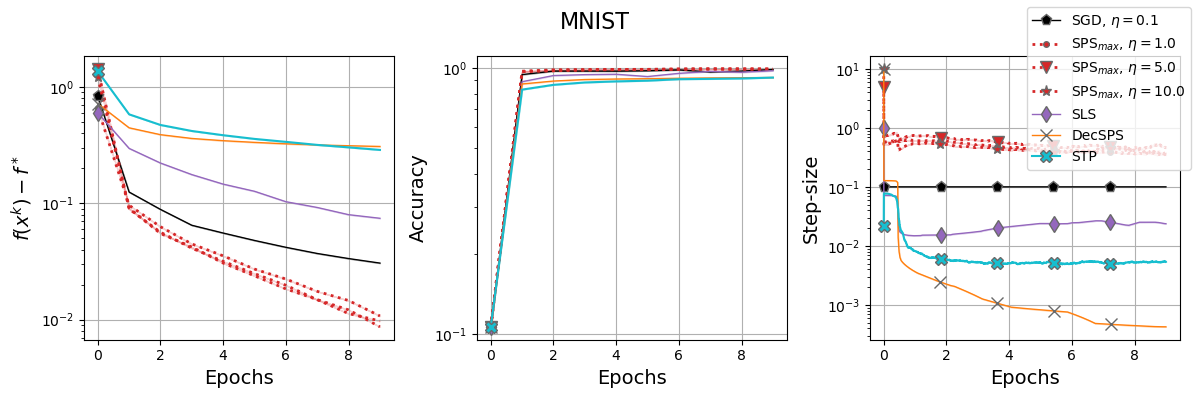

In [66]:
plotter(histories=histories, 
        colors=["black", "tab:red", "tab:red", "tab:red", "tab:purple", "tab:orange", "tab:cyan"],
        linestyles=["-", ":", ":", ":", "-", "-", "-"],
        linewidths=[1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.5],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=8,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8],
        f_star=np.asarray(0.0), 
        x_labels=["Epochs", "Epochs", "Epochs", "Epochs"],
        y_labels=[r"$f(x^k) - f^*$", "Accuracy", "Step-size", r"$\| \nabla f(x^k) \|^2$", "Test Accuracy", r"Step-size"],
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"MNIST",
        metrics=["train/loss", "test/accuracy/top1", "lr"],
        y_scales=["log", "log", "log", "log"],
        mov_ave=[True, True, True, True],
        # threshold=0.0,
        # acc_ylim=0.7,
        # filename=f"{dataset_name}_stochastic_logreg_4.pdf",
        )

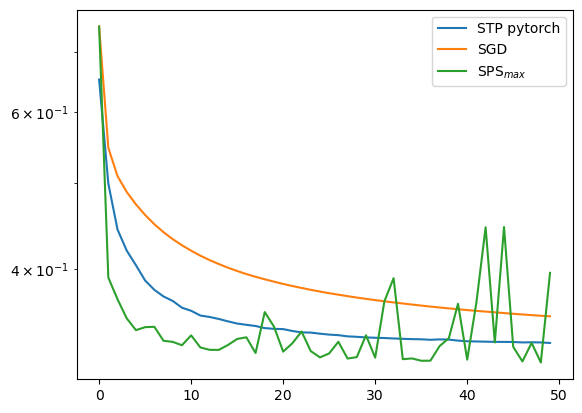

In [491]:
plt.semilogy(hist_stp["train/loss"], label="STP pytorch")
plt.semilogy(hist_sgd["train/loss"], label="SGD")
plt.semilogy(hist_sps["train/loss"], label=r"SPS$_{max}$")
plt.legend()

In [463]:
hist_np = utils.load_results(
    loss="logreg",
    setting="stochastic",
    dataset_name="a1a",
    batch_size=batch_size,
    n_epochs=200,
    optimizer="STP",
    lr="1_0",
    seed=0
)

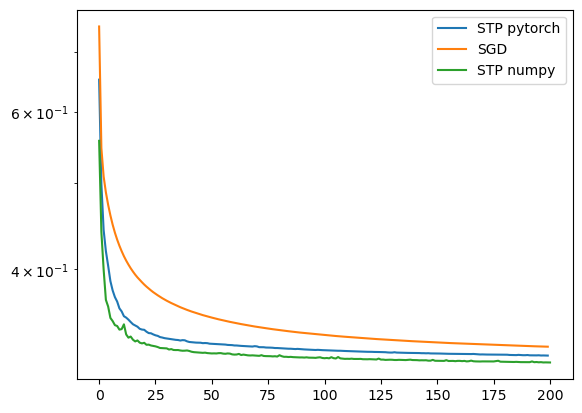

In [464]:
plt.semilogy(hist_stp["train/loss"], label="STP pytorch")
plt.semilogy(hist_sgd["train/loss"], label="SGD")
plt.semilogy(hist_np["train/loss"], label="STP numpy")
plt.legend()